# Predicting Palmera Chocolate

We are going now to examine and treat our first series: palmera de chocolate.
    
Along this script we will:
    
    1) Paint the series, examine its autocorrelations and seasonality and get some useful insights.
    2) Apply different kinds of models to it, particularly time series models and machine learning models, also, when neuronal networks will be considered.
    3) Check the results we get from each method and extract our conclusions

# 1) Introductory examination

We import the required packages and our dataframe, and extract from it our series.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing tools from statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa as tsa
from statsmodels.tsa import seasonal
from statsmodels.tsa import stattools as stto

from datetime import timedelta

plt.style.use('ggplot')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# train-test split library
from sklearn.model_selection import train_test_split

# ERRORS
from sklearn.metrics import mean_squared_error
from fbprophet.diagnostics import performance_metrics

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

#PROPHET
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 5

In [21]:
sep=";"
exit_path = "../../data/03_processed/" + "time_series.csv"

In [22]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [23]:
df=pd.read_csv(exit_path, sep=sep, parse_dates=True, index_col='order_date')

In [24]:
palmera_choco=df[df['product']=='palmera chocolate'][['units_ordered','festivo','weight']]

Now, we check our series, by plotting it and getting its first statistical values:

### 1.1) Series plot and first values

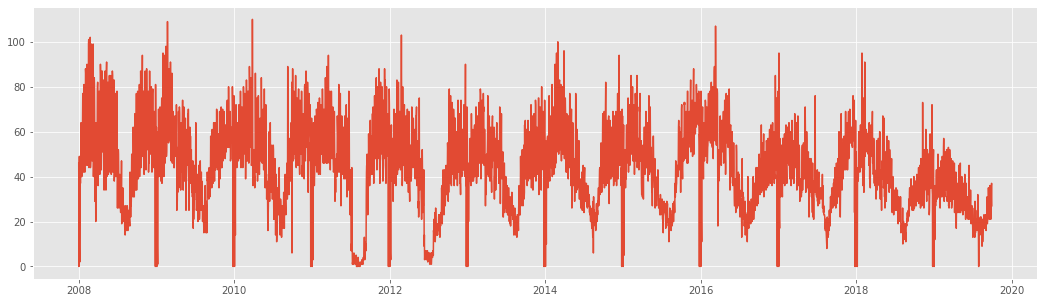

In [25]:
plt.plot(palmera_choco['units_ordered'])

#Important note: due to a bug in prophet series.plot() does not work

In [26]:
palmera_choco['units_ordered'].describe()

count    4291.000000
mean       43.670007
std        18.076184
min         0.000000
25%        32.000000
50%        43.000000
75%        55.000000
max       110.000000
Name: units_ordered, dtype: float64

As we can see, the series is possibly stationary: it has (at first glance) no trend, and no changes in variance.
    
We can also see that its mean value is about 43, and that there is no much difference between its mean and its median value, what is a good sign for the skewness.

We can also see that the series has a great dispersion in its daily values.

In order to smooth it and get some other insights, let's get and plot the series for the monthly average data.

### 1.2) Augmented Dickey-Fuller test

We are now going to check wether our series has any root bigger than 1 or it does not, in order to check its stationarity.

In a time series, if the process's characteristic equation presents a root with a value greater than 1, then the process will be non stationary.

So, in order to get stationarity for a determined process, all its roots of the characteristic equation must lie inside the unit circle—that is, have a modulus (absolute value) of less than one.

This is tested using the augmented Dickey-Fuller test.

The augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.

The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

In [27]:
adf_test_results = adfuller(palmera_choco['units_ordered'])

print("p-value: ", adf_test_results[1])
print("test value:", adf_test_results[0])
print("% confidence p-values: ", adf_test_results[4])

p-value:  4.860621460902781e-07
test value: -5.791487673614479
% confidence p-values:  {'1%': -3.43188633380603, '5%': -2.8622188674189872, '10%': -2.5671313664110107}


As we can see, the p value is about 0. Also, comparing the test value with the p-values for the 1% p-value (-5.79 to -3.43) we can see that we can clearly state that our series is stationary or trend-stationary.

### 1.3) Monthly averages and yearly seasonality

We are going to aggregate the data by month, stabiblishing their means, to check for the appearance of any patterns:

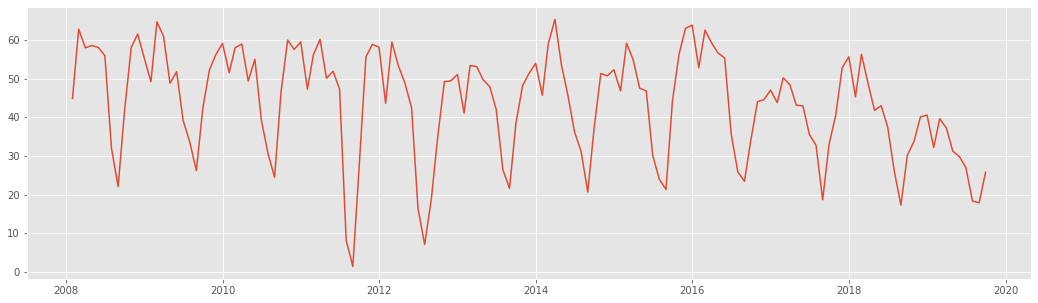

In [28]:
monthly  = palmera_choco.reset_index().groupby(pd.Grouper(key='order_date', freq='M'))['units_ordered'].mean()
plt.plot(monthly)
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as there is always a bump in orders during the middle the year.

We can see also that the series lacks a clear trend.

We also can see that the series presents minimums once a year, being more pronounced at 2011 and 2012.

We aree going to plot a couple of years to check where these minimums occur.

In [29]:
monthly.reset_index().head()

,order_date,units_ordered
0,2008-01-31,44.870968
1,2008-02-29,62.758621
2,2008-03-31,57.935484
3,2008-04-30,58.533333
4,2008-05-31,58.000000


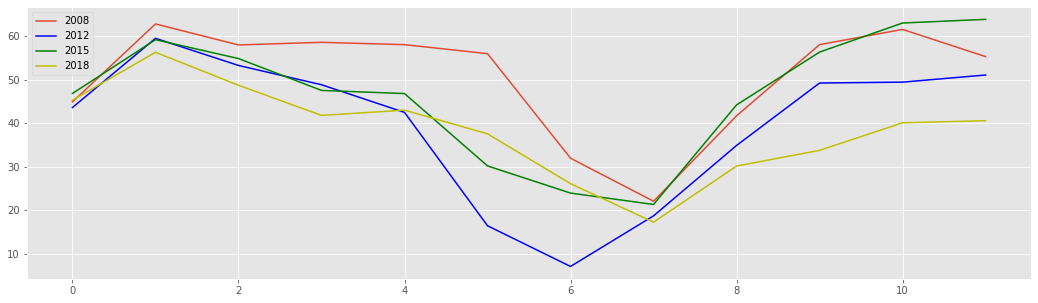

In [30]:
plt.plot(monthly['2008'].reset_index()['units_ordered'])
plt.plot(monthly['2012'].reset_index()['units_ordered'], color='b')
plt.plot(monthly['2015'].reset_index()['units_ordered'], color='g')
plt.plot(monthly['2018'].reset_index()['units_ordered'], color='y')
plt.legend(['2008','2012','2015','2018'])
plt.show()

As we can see, for 3 out of the 4 values plotted, the mininum value is found in the month of August.

For the fourth series, the minimum appears at July.

Maximums appear in January for all series.

We have found that there is a clear yearly seasonality in our series.

Talking about seasonality, we are going to check now for autocorrelations, and we will use the information that we have extracted for our graphs above to use it in our favor when looking for such autocorrelations.

### 1.3) Autocorrelation, ACF and PACF

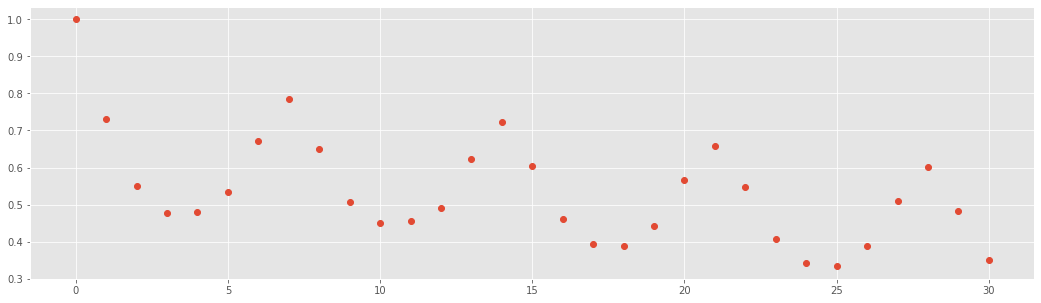

In [31]:
p_choc_acf=stto.acf(palmera_choco['units_ordered'], nlags=30)

plt.plot(p_choc_acf, 'o')

We check the plot with the plot_acf function that statsmodels also provides us, and that includes a visual p-value: a range(that can be seen below, red-shaded region) where values could be due to chance, up to a certain confidence level (or, to be more precise, a region of values that cannot be discarded as being being produced by chance):

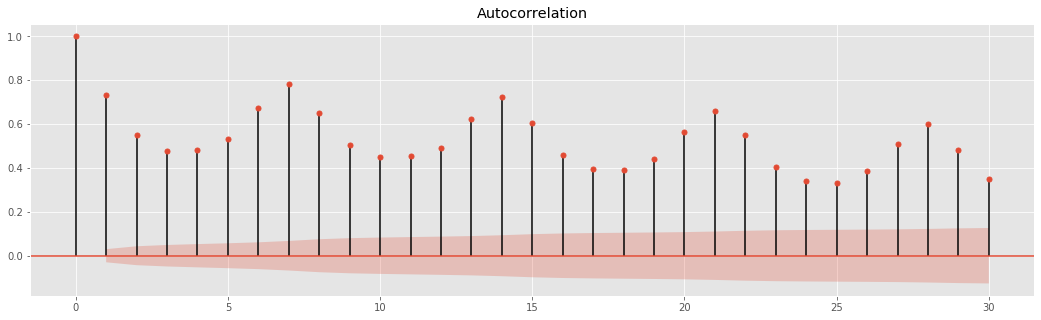

In [32]:
plot_acf(palmera_choco['units_ordered'], lags=30);

As we can see, our series presents both a strong relationship with its n-1 lag (correlation of about 0.75, and also a clear weekly autocorrelation (of about 0.8 - 0.75^6 ≈ 0.6).

As we know, if our process follows an AR(x) model, the value n will have a relation to value n-x of value alpha, then will present a correlation with the value n-2\*x of alpha^2, and a correlation of alpha^3 with the value n-3\*x and so on.

Also, appart from the stated, we cannot discard any of the correlations with the values up to the 7th.

Now, as we saw previously that a strong yearly seasonality existed, we are going now to check for autocorrelations in a more ample spectrum:

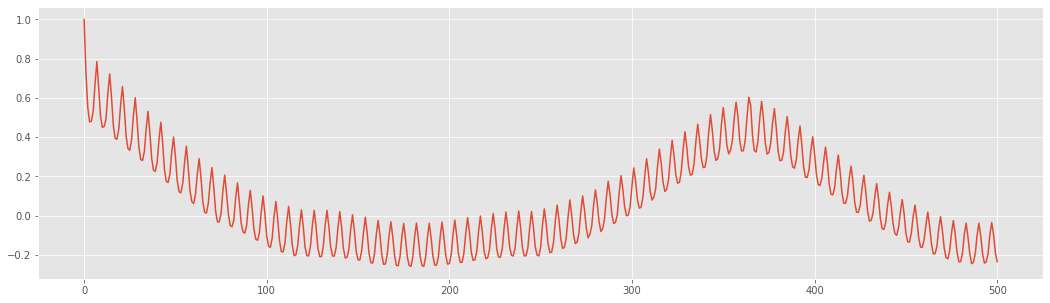

In [33]:
p_choc_acf=stto.acf(palmera_choco['units_ordered'], nlags=500)

plt.plot(p_choc_acf)

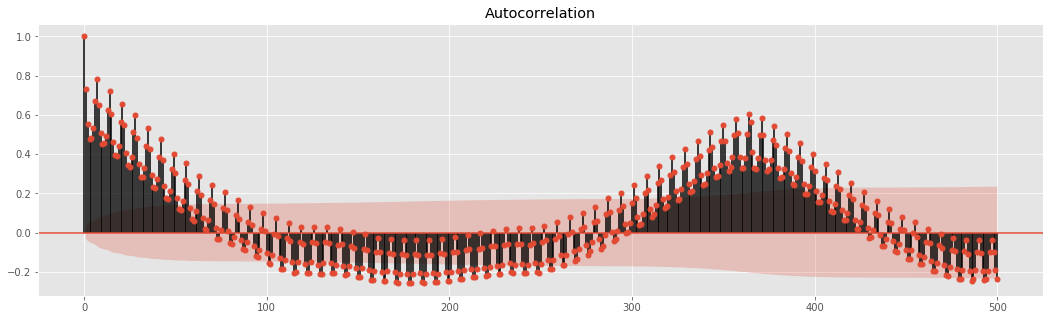

In [34]:
plot_acf(palmera_choco['units_ordered'], lags=500);

As we can see, there is a sinusoidal behaviour, and that the series presents a peak at lag 365.

We are checking that using our average monthly data, so we can get rid off the strong autocorrelations found in our daily series.

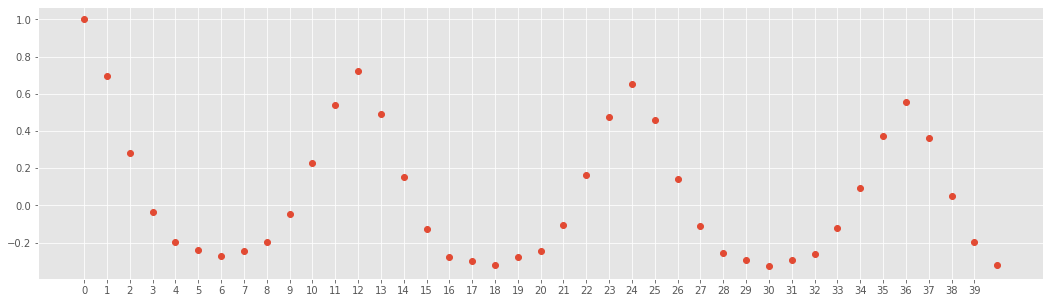

In [35]:
p_choc_acf=stto.acf(monthly, nlags=40)

plt.plot(p_choc_acf,  'o')
plt.xticks(list(range(40)));

We find a strong relationship involving each month with the same month of the previous year, showing, again, the yearly seasonality that we found during section 1.2.

Finally, we are checking the partial autocorrelation function, that shows us how much residual information is explained by adding a new lag.

PACF, instead of finding correlations of present with lags like ACF, finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. 

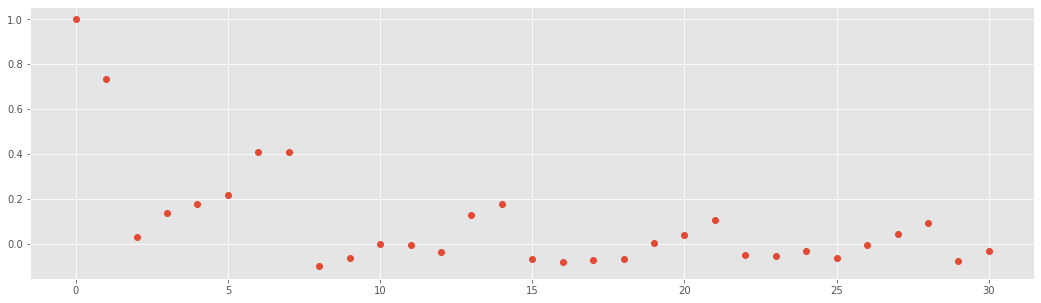

In [36]:
p_choc_acf=stto.pacf(palmera_choco['units_ordered'], nlags=30)

plt.plot(p_choc_acf, 'o')

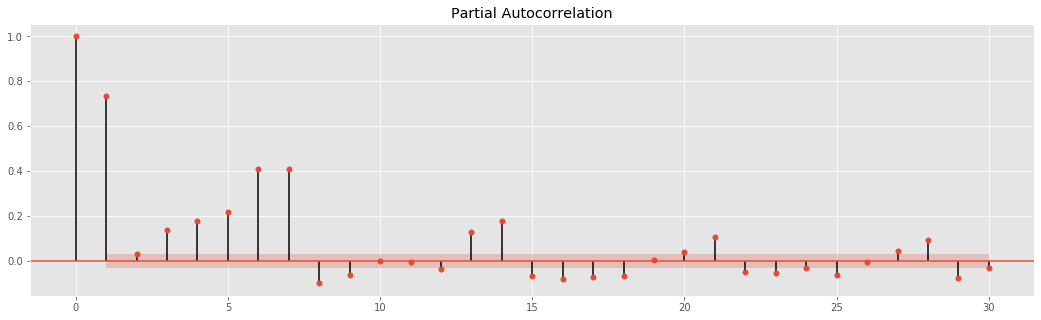

In [37]:
plot_pacf(palmera_choco['units_ordered'], lags=30);

The PACF confirms us what we saw in the acf: the series presents a strong correlation with its first lag (being most of the rest of the spikes merely the result of the propagation of the autocorrelation at lag 1), but there is also a strong autocorrelation with lags 6 and 7. So, in general, autoregressive models of order 7 will be needed to explain the series.

### 1.4) Series decomposition

Finally, to get a better grip on our series before studying it by any methods, we are going now to decompose the series using the seasonal_decompose tool provided in the statsmodel package.

This method uses moving averages to detrend the series and extract the seasonality.

It will give us another first impression on what we can expect about its behaviour, and also what methods should be in order for its analysis and forescasting.

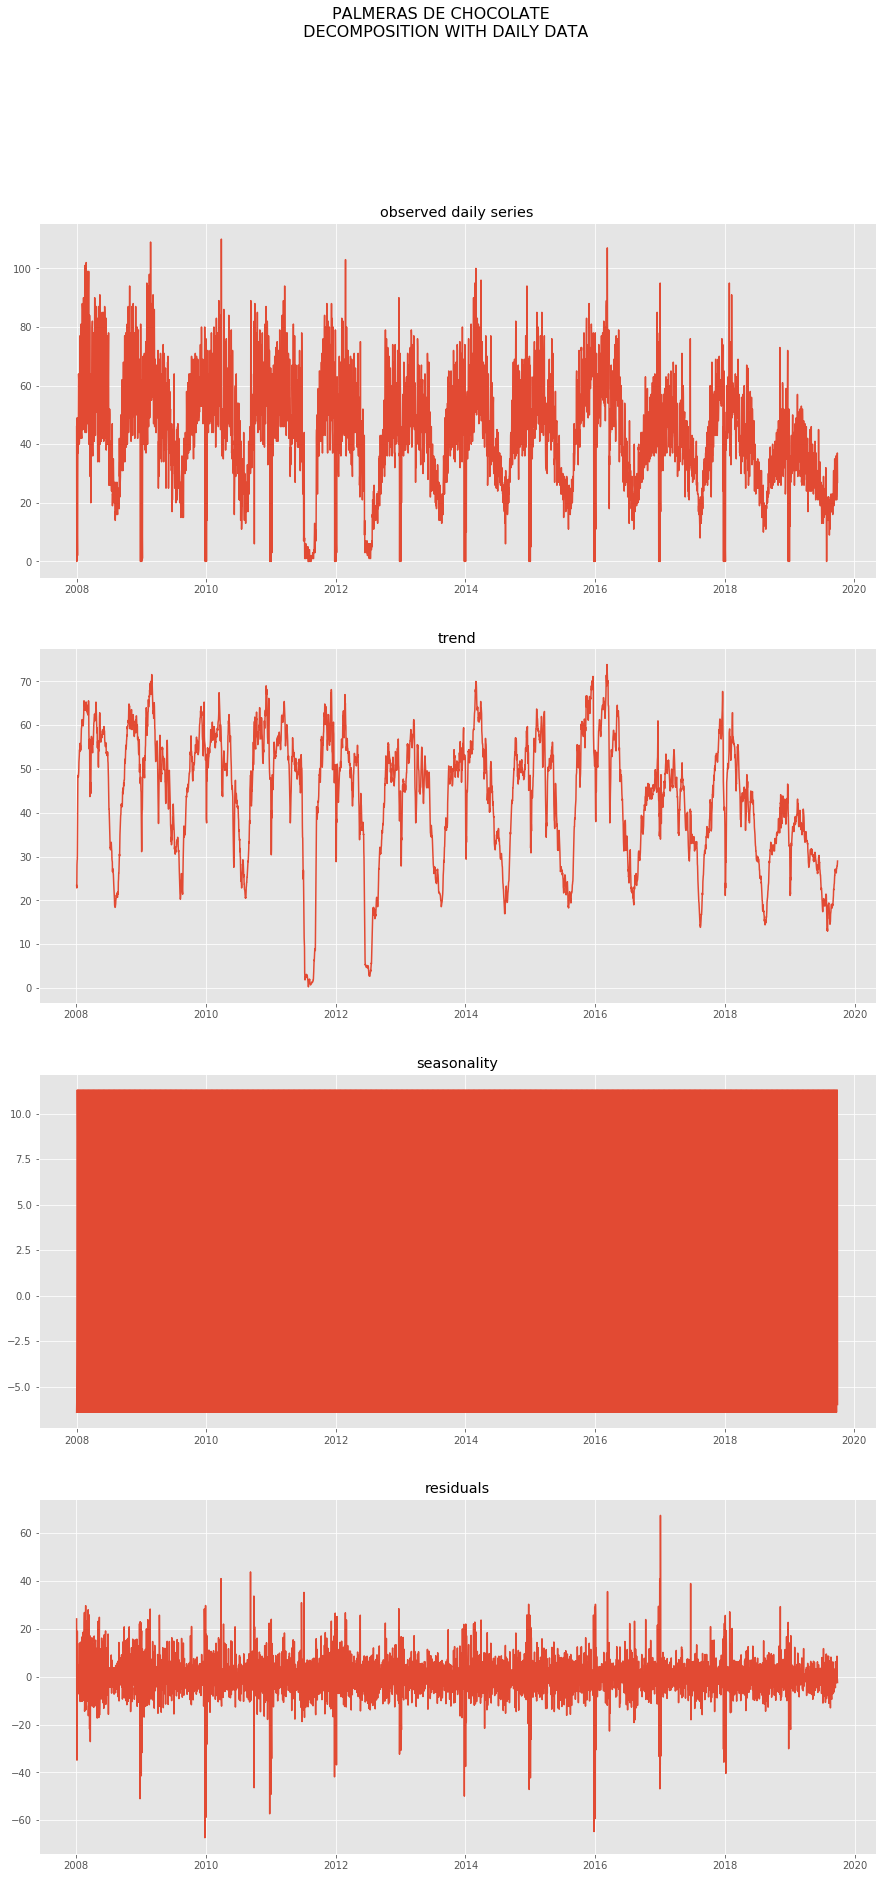

In [38]:
decomposition = seasonal.seasonal_decompose(palmera_choco['units_ordered'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,30))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH DAILY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');


We cannot see a thing with the whole series, due to the constraints of the image. We are going to run the same procedure with just one year of data:

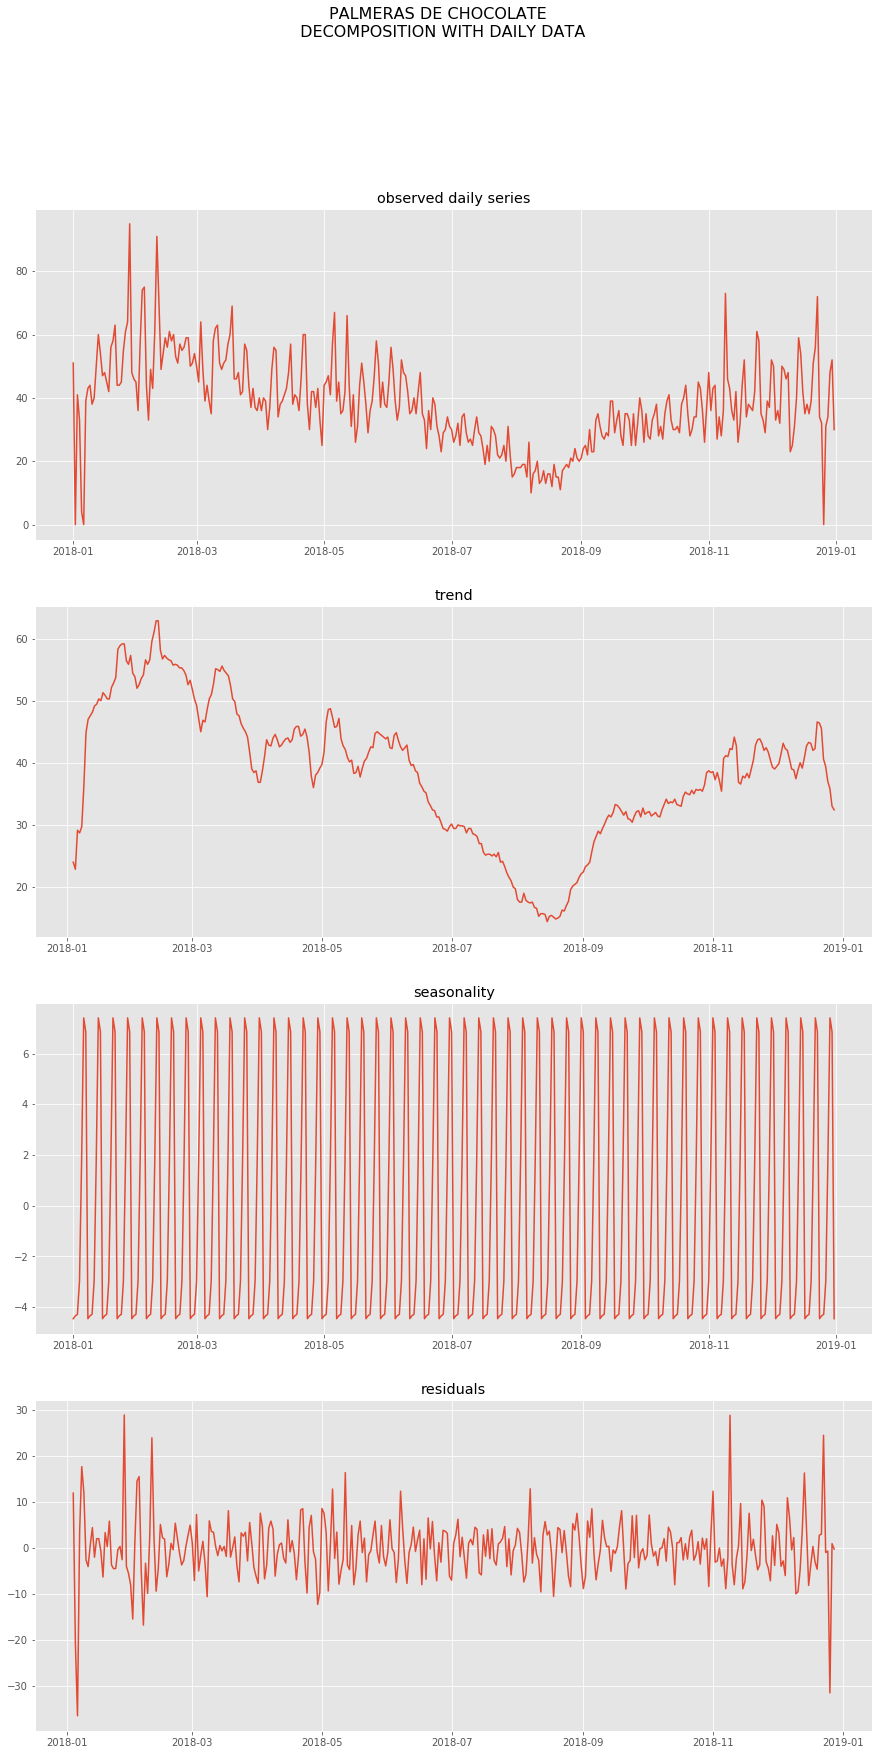

In [39]:
decomposition = seasonal.seasonal_decompose(palmera_choco.loc['2018','units_ordered'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,28))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH DAILY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');

From this decomposition we can extract two main conclusions:

* There is a strong seasonality week component.

* As we can see, the dcomposition is not working well for the series of the daily data. Let's see what it can do with the series of monthly averages:

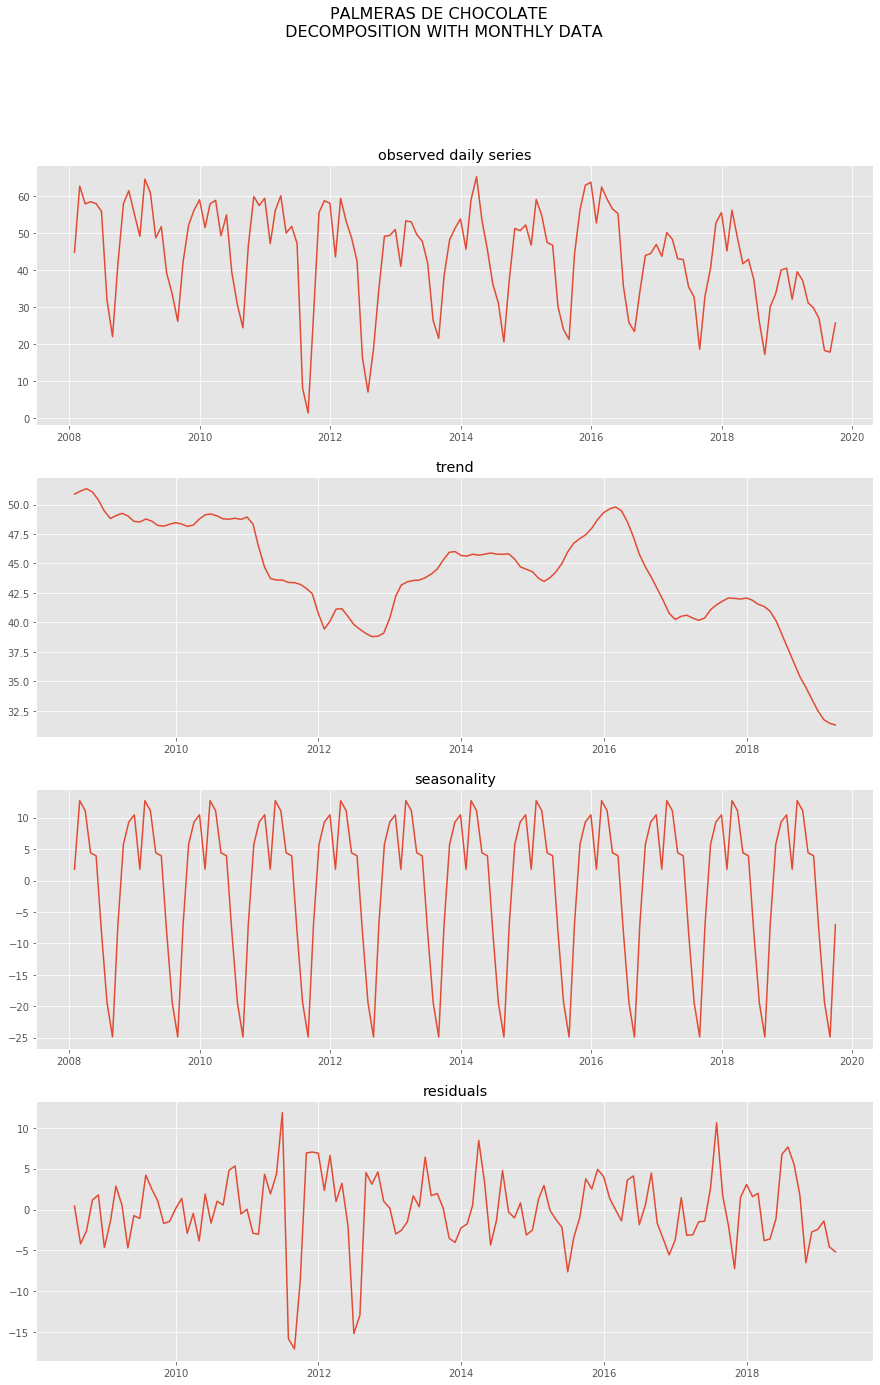

In [40]:
decomposition = seasonal.seasonal_decompose(monthly, model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,22))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH MONTHLY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');

# 2) Models application

### 2.0) Split Train-Test, Initialize Results Dictionary and setting benchmarks

In [41]:
# With Feature
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

In [64]:
# Without Features
# train_size = int(len(palmera_choco["units_ordered"]) * 0.95)
# train, test = palmera_choco.iloc[0:train_size,0], palmera_choco.iloc[train_size:,0]

In [98]:
import random

In [112]:
series.head()

order_date
2008-01-01    46.0
2008-01-02     0.0
2008-01-03    36.0
2008-01-04    49.0
2008-01-05     9.0
Name: units_ordered, dtype: float64

In [369]:
series = palmera_choco["units_ordered"]

random.seed(17)

number_of_validations = 10

cross_val_dict=dict()

for i in range(1,number_of_validations):

    ran_num = random.randint(365,len(series))
    ran_test_dates = series.reset_index().iloc[ran_num:ran_num+6]['order_date']
    ran_train_dates = series.reset_index().iloc[ran_num-365:ran_num]['order_date']

    test = series[ran_test_dates]
    train = series[ran_train_dates]

    cross_val_dict['cv'+str(i)]=[train, test]

We create now an empty dictionary where we will input the error obtained by each method used.

In [365]:
# Error per model Dictionary
mse_all_models = {} 

We are now going to set our benchmarks for comparison:

**BENCHMARK 1:**

USING THE MEAN AS A GUESS:

Our first "models" will be: Using the mean as a guess (the most basic model). This first value will provide us with a first tool to calibrate the other two models that we are going to use for benchmarking our time series and machine learning models:

In [374]:
squared_dif_series.reindex(range(0,len(squared_dif_series)))

order_date
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: units_ordered, dtype: float64

In [372]:
mean_total_error = 0

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    train_mean = train.mean()
    print("mean (model predicted value):", train_mean)
    squared_dif_series=(test - train_mean)**2
    print("MSE:", (squared_dif_series).mean())
    
    mean_total_error = mean_total_error + (squared_dif_series).mean()
    
    mean_squared_dif_series = squared_dif_series.reindex(range(0,len(squared_dif_series)))
    
mean_total_error = mean_total_error/number_of_validations

print("mean MSE:", mean_total_error)

mean (model predicted value): 45.84109589041096
MSE: 69.98643773065615
mean (model predicted value): 43.106849315068494
MSE: 511.1173528491901
mean (model predicted value): 41.131506849315066
MSE: 167.96615249890542
mean (model predicted value): 42.13972602739726
MSE: 141.09577907049479
mean (model predicted value): 39.04109589041096
MSE: 433.7573966347657
mean (model predicted value): 42.73972602739726
MSE: 215.4421717645587
mean (model predicted value): 49.221917808219175
MSE: 267.7054118971666
mean (model predicted value): 40.76986301369863
MSE: 389.75752924250963
mean (model predicted value): 46.723287671232875
MSE: 69.30625007818851
mean MSE: 226.61344817664357


We now plot the results for the last of our models:

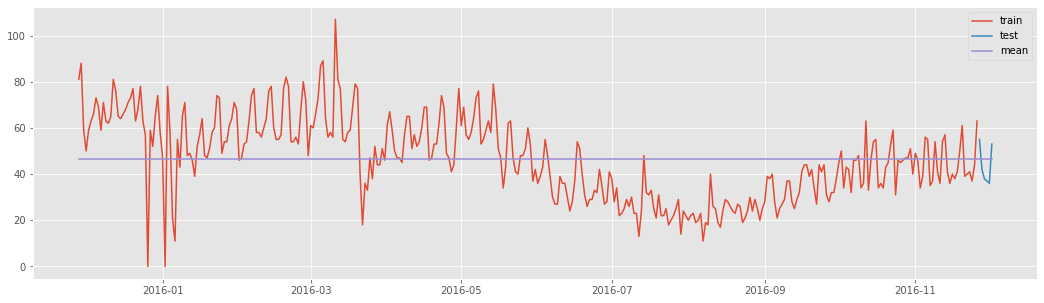

In [373]:
mean_model = pd.Series(train_mean, index = train.index.union(test.index))

plt.plot(train)
plt.plot(test)
plt.plot(mean_model)
plt.legend(['train','test','mean'])

As we can see, the mean fails to capture any trend along the cycle, nor the weekly seasonality.

**BENCHMARK 2:**
    
MEAN OF JUST SAME DAYS OF THE WEEK:
    
Now we will guess each value with the mean of the values of its weekday:

In [276]:
train_means_by_weekday = train.groupby(train.index.weekday).mean()
train_means_by_weekday

order_date
0    38.942308
1    39.326923
2    39.653846
3    40.134615
4    46.150943
5    57.826923
6    58.846154
Name: units_ordered, dtype: float64

As we can see, when compared with the general mean, we have a certain ammount of dispersion. 

As now our guesses should be wiser, our median average error should go down.

In fact, we can calculate a first rough upper limit of how much better we should do.

If the behaviour in our data was perfect, the mean excess in error in the mean squared error commited by our previous method by not discerning by weekday should be the mean squared error of the difference of this two gueses, so:

In [277]:
mean_squared_error(train_means_by_weekday, [train_mean]*7)

67.68018519513488

This number is the upper bound of the possible improvement in our MSE.

Our new model could reduce our error from the previous up to 67 points, but in general the reduction will be far less and sometimes, this new approximation could even produce even more error than just using the mean.

Let's check it:

In [278]:
test_df=test.reset_index()
test_df['weekday'] = test.index.weekday

In [279]:
df_train_means_by_weekday = train_means_by_weekday.reset_index()
df_train_means_by_weekday.columns = ['weekday','prediction']

test_result_merged = pd.merge(test_df, df_train_means_by_weekday, how='inner', on='weekday')
test_result_merged.set_index(test_result_merged['order_date'], inplace=True)
test_result_merged.sort_index(inplace=True)

In [280]:
test_result_merged['Sq_error'] = (test_result_merged['units_ordered'] - test_result_merged['prediction'])**2
test_result_merged['Sq_error'].mean()

37.34124642927918

Again, we check with the built-in function:

In [281]:
mean_squared_error(test_result_merged['units_ordered'], test_result_merged['prediction'])

37.341246429279174

So, insted experiencing an improvement, in this particular case the model has done worse.

Now, we plot the values of the model against the real values:

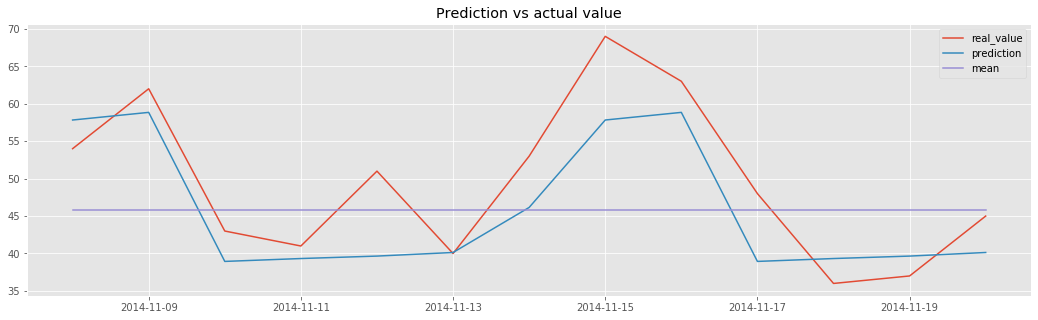

In [307]:
plt.plot(test_result_merged['units_ordered'])
plt.plot(test_result_merged['prediction'])
plt.plot(mean_model[test.index])
plt.legend(['real_value','prediction','mean'])
plt.title('Prediction vs actual value');

As we can see, the new benchmark model now adjusts well to the weekly seasonality. Let's check how this is translated in the distribution of the error:

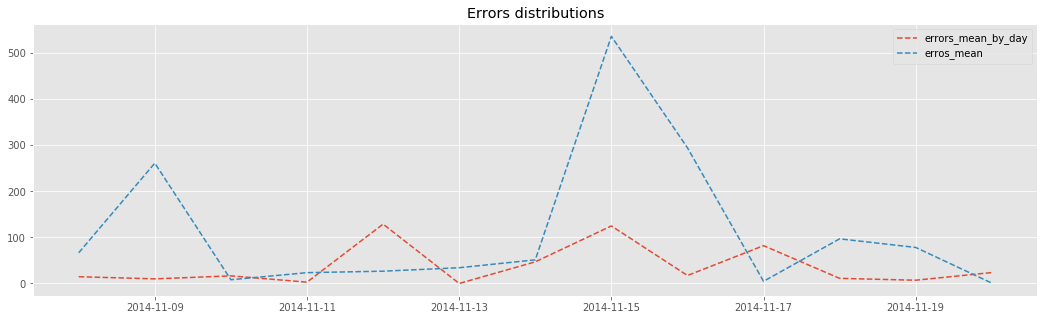

In [306]:
plt.plot(test_result_merged['Sq_error'], '--')
plt.plot(squared_dif_series, '--')
plt.legend(['errors_mean_by_day','erros_mean'])
plt.title('Errors distributions');

Our error is not only significantly lower, but also more uniform in its distribution along time, which is another factor to keep in mind.

**BENCHMARK 3:**
    
NAÎVE GUESS:
    
Now we are going to predict the values of our series just by using the last value available, again, for the same day of the week.

This method presents an inconvenience over the former, which is that we cannot predict a series of days in advance, just the week ahead (indeed, we could predict n weeks beforehand, but our predictions would be the same for each week).

As an advantage, this method frees us from needing a great amount of data at our disposal, as just a record of a week of data allows us to make predictions:

In [290]:
train_bm3 = train[-7:]

In [291]:
train_bm3

order_date
2014-11-01    65.0
2014-11-02    63.0
2014-11-03    46.0
2014-11-04    39.0
2014-11-05    39.0
2014-11-06    57.0
2014-11-07    54.0
Name: units_ordered, dtype: float64

In [292]:
train_bm3.index = train_bm3.index + timedelta(days=7)
pred_bm3 = test.shift(7)
pred_bm3.fillna(0, inplace=True)
pred_bm3[0:7] = pred_bm3[0:7] + train_bm3

In [304]:
df_bm3 = pd.DataFrame(test)
df_bm3['prediction'] = pred_bm3
df_bm3['Sq_error'] = (df_bm3['units_ordered'] - df_bm3['prediction'])**2
df_bm3['Sq_error'].mean()

82.0

In [305]:
mean_squared_error(df_bm3['units_ordered'], df_bm3['prediction'])

82.0

We can see that our error has gone up dramatically.

Now, plotting the distributions:

Text(0.5, 1.0, 'Prediction vs actual value')

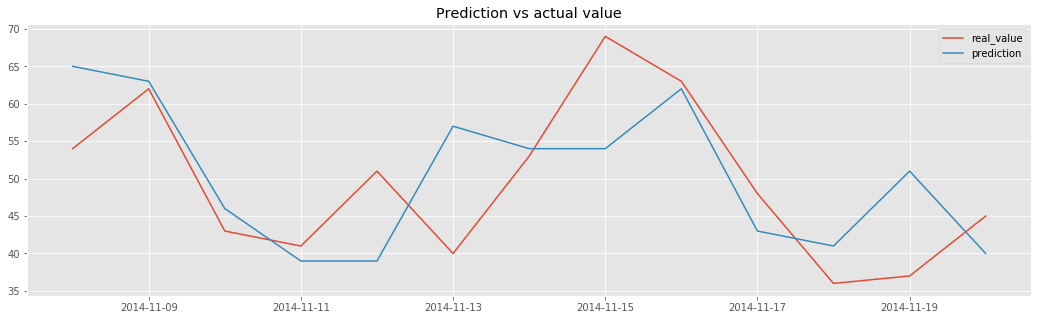

In [301]:
plt.plot(df_bm3['units_ordered'])
plt.plot(df_bm3['prediction'])
plt.legend(['real_value','prediction'])
plt.title('Prediction vs actual value')

We can see that the series again is capable of adjusting to the general data.

Let's see now the distribution of errors:

Text(0.5, 1.0, 'Errors distributions')

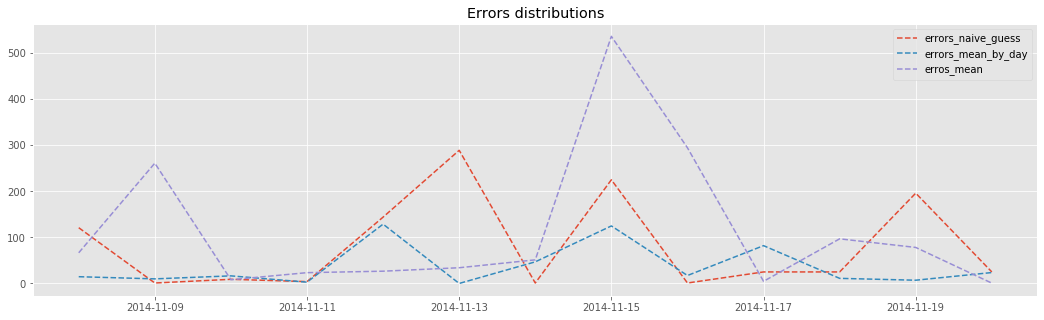

In [300]:
plt.plot(df_bm3['Sq_error'], '--')
plt.plot(test_result_merged['Sq_error'], '--')
plt.plot(squared_dif_series, '--')
plt.legend(['errors_naive_guess','errors_mean_by_day','erros_mean'])
plt.title('Errors distributions')

We can see that, in this case, the results for the distribution of errors are halfway the two previous scenarios.

### 2.1) TIME SERIES METHODS

Now, we can start using time series methods for our forecasts.

### 2.1.1) EXPONENTIAL MODELS

Each model consists of a measurement equation that describes the observed data, and some state equations that describe how the unobserved components or states (level, trend, seasonal) change over time. Hence, these are referred to as state space models.

For each method there exist two models: one with additive errors and one with multiplicative errors. The point forecasts produced by the models are identical if they use the same smoothing parameter values. They will, however, generate different prediction intervals.

We label each state space model as ETS(.,.,.) for (Error, Trend, Seasonal). This label can also be thought of as ExponenTial Smoothing, where  the possibilities for each component are:

 - Error: Additive, Multiplicative
 - Trend: None, Additive, Additive and damped
 - Seasonal: None, Additive, Multiplicative
 
 
 This leads to the following map:
 
<img src=".\statespacemodels.png" style="width: 620px;">


Three of the combinations of (Error, Trend, Seasonal) can lead to numerical difficulties. Specifically, the models that can cause such instabilities are ETS(A,N,M), ETS(A,A,M), and ETS(A,Ad,M), due to division by values potentially close to zero in the state equations. We normally do not consider these particular combinations when selecting a model.

Models with multiplicative errors are useful when the data are strictly positive, but are not numerically stable when the data contain zeros or negative values. Therefore, multiplicative error models will not be considered if the time series is not strictly positive. In that case, only the six fully additive models will be applied.

Source:

https://otexts.com/fpp2/ets.html

So, being that our case, we will opt for a damped Additive Holt-Winters’ method (an exponential method with additive, damped trend and additive seasonality) with additive errors.

In [62]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [95]:
palmera_choco['units_ordered'].head()

order_date
2008-01-01    46.0
2008-01-02     0.0
2008-01-03    36.0
2008-01-04    49.0
2008-01-05     9.0
Name: units_ordered, dtype: float64

In [85]:
ES_model = ExponentialSmoothing(train, trend='add', seasonal='add', damped=True, seasonal_periods=7)
ES_model = ES_model.fit()

print(ES_model.summary)

ES_resid = ES_model.resid
ES_aic = ES_model.aic

ES_pred = ES_model.predict(start = test.index[0], end = test.index[-1])

ES_mse = (test - ES_pred)**2

<bound method Results.summary of <statsmodels.tsa.holtwinters.HoltWintersResults object at 0x0000020AFB7A4AC8>>


NameError: name 'ARIMA_mse' is not defined

In [87]:
ES_model.plot_predict(start = test.index[0], end = test.index[-1])

AttributeError: 'HoltWintersResults' object has no attribute 'plot_predict'

In [86]:
print(ES_mse.mean())

260.75892713459353


### 2.1.2) ARIMA

The ARIMA model for time series analysis and forecasting can be tricky to configure, for this reason we will use Grid Search to automate the process of training and evaluating ARIMA models on different combinations of model hyperparameters.
We will be following for the following notebook as a base line: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
    

The steps that suggested to follow are:

1. Split the dataset into training and test sets.
2. Walk the time steps in the test dataset.
3. Train an ARIMA model.
4. Make a one-step prediction.
5. Store prediction; get and store actual observation.
6. Calculate error score for predictions compared to expected values.

The dataset is split in two: 75% for the initial training dataset and the remaining 25% for the test dataset.
Each time step of the test set is iterated. Just one iteration provides a model that you could use to make predictions on new data. The iterative approach allows a new ARIMA model to be trained each time step.
A prediction is made each iteration and stored in a list. This is so that at the end of the test set, all predictions can be compared to the list of expected values and an error score calculated. In this case, a mean squared error score is calculated and returned.

In [88]:
ARIMA_model = ARIMA(train, order=(7,0,1))
ARIMA_model = ARIMA_model.fit()

print(ARIMA_model.summary)

ARIMA_resid = ARIMA_model.resid
ARIMA_aic = ARIMA_model.aic

ARIMA_pred = ARIMA_model.predict(start = test.index[0], end = test.index[-1])

ARIMA_mse = (test - ARIMA_pred)**2

print(ARIMA_mse.mean())

<bound method ARMAResults.summary of <statsmodels.tsa.arima_model.ARMAResults object at 0x0000020AF8C5B3C8>>
341.97230116583904


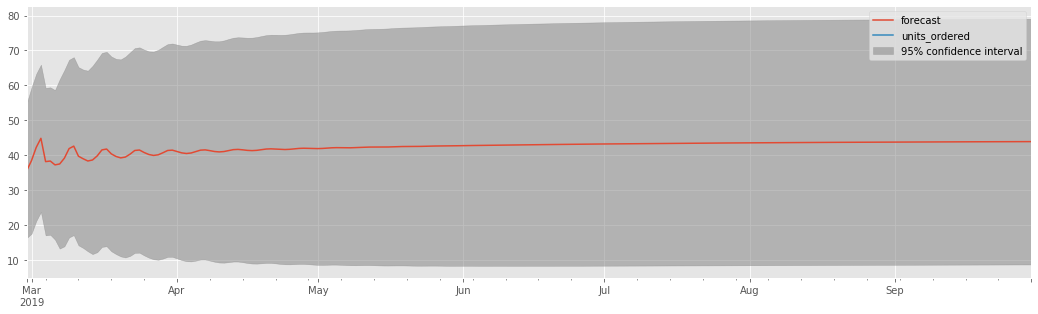

In [90]:
# Plot the original series and the forecasted series
pd.plotting.register_matplotlib_converters()
ARIMA_model.plot_predict(start = test.index[0], end = test.index[-1]);

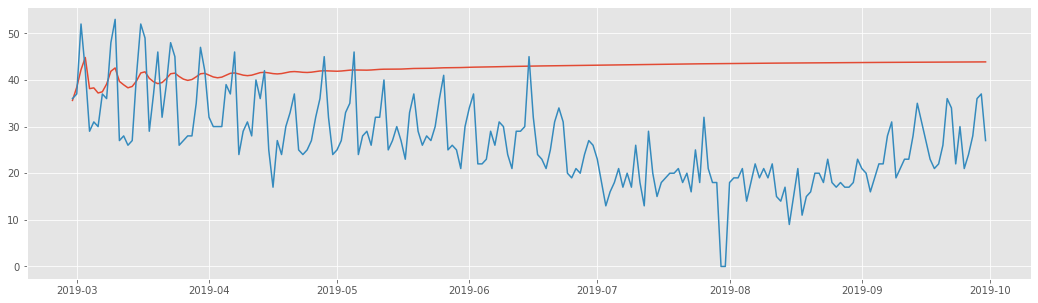

In [93]:
plt.plot(ARIMA_pred)
plt.plot(test)

In [ ]:
ARIMA_model = ARIMA(train, order=(7,0,1))
ARIMA_model = ARIMA_model.fit()

print(ARIMA_model.summary)

ARIMA_resid = ARIMA_model.resid
ARIMA_aic = ARIMA_model.aic

ARIMA_pred = ARIMA_model.predict(start = test.index[0], end = test.index[-1])

ARIMA_mse = (test - ARIMA_pred)**2

print(ARIMA_mse.mean())

We define now a function that obtains all this values for us:

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def eval_arima_model(arima_order, train , test):
    
    # make predictions
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    
    model_summary = ARIMA_model.summary

    model_resid = ARIMA_model.resid
    model_aic = ARIMA_model.aic
    
    yhat = model_fit.predict(start = test.index[0], end = test.index[-1])

    # calculate out of sample error
    model_error = mean_squared_error(test, yhat)
    
    return model_summary, model_resid, model_aic, yhat, model_error

Checking that the function works propperly:

In [ ]:
ARIMA_summary, ARIMA_resid, ARIMA_aic, yhat, ARIMA_error = eval_arima_model([10,0,1], train, test)
print(ARIMA_error)
print(ARIMA_aic)

Now, we use this function to try out several different combinations for the parameters of the ARIMA model:

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values, train , test):
    print("starting...") 
#     train = train.astype('float32')
#     test = test.astype('float32')
    b_model_summary, b_model_resid, b_model_aic, b_yhat, b_error  = None, None, None, None, float("inf")
    for p in p_values:
        for d in d_values:
            for q in q_values:
                
                order = (p,d,q)
                
                model_summary, model_resid, model_aic, yhat, error = eval_arima_model(order, train, test)
                
                if error < b_error:
                    
                    b_model_summary, b_model_resid, b_model_aic, b_yhat, b_error = model_summary, model_resid, model_aic, yhat, error
                    b_order = order
                    
                print('ARIMA%s MSE=%.3f AIC=%.3f' % (order,error, model_aic))
                    
    print('Best ARIMA %s MSE=%.3f AIC=%.3f' % (b_order,b_error, b_model_aic))
    
    return b_order, b_model_summary, b_model_resid, b_model_aic, b_yhat, b_error

In [ ]:
p_values = [0,1,7,8,10,14]
d_values = [0,1] # Coefficient to remove trend. The larger the order trend, the larger the value.
q_values = [0,1,2]  #
#best_score=evaluate_models(p_values, d_values, q_values, train, test)

In [ ]:
mse_all_models["ARIMA"] = evaluate_models(p_values, d_values, q_values, train, test)

### 2.2) PROPHET

In [ ]:
train_for_prophet = train.reset_index()
train_for_prophet = train_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})
palmera_choco_prophet_model = Prophet(interval_width=0.95)
palmera_choco_prophet_model.fit(train_for_prophet)


palmera_choco_forecast = palmera_choco_prophet_model.make_future_dataframe(periods=36, freq='MS')
palmera_choco_forecast = palmera_choco_prophet_model.predict(palmera_choco_forecast)

plt.figure(figsize=(18, 6))
palmera_choco_prophet_model.plot(palmera_choco_forecast, xlabel = 'Date', ylabel = 'Orders')
plt.title('Palmera Chocolate- Oreders Forecast')

In [ ]:
test_for_prophet = test.reset_index()
test_for_prophet = test_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})
predictions = palmera_choco_prophet_model.predict(test_for_prophet)

In [ ]:
mse_prophet = mean_squared_error(test_for_prophet["y"], predictions["yhat"])
mse_prophet

In [ ]:
df_cv = cross_validation(palmera_choco_prophet_model, initial='366 days', period='365 days', horizon = '20 days')
df_cv.head()

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head(5)

In [ ]:
df_p['mse'].plot()

In [ ]:
mse_all_models["Prophet"] = mse_prophet

### 2.2) RANDOM FOREST

Lets now try rarandom forest with only the time series as input. The steps we will need to follow are:

1. Transform the data: each row should contain the features (previous days, matches, etc)
2. Fit the model with train
3. Predict with test
4. Evaluate the error.

Lets start creating the function that will transform the data, which was adapted from the following site: https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/

In [ ]:
def data_transformation(series, n_lag, lead_time):
    """ Takes a series, a number of lag observations to use as input, 
    and a forecast lead time to predict, then will return a list of input/out 
    rows drawn from the series """

    data = list()
    # enumerate observations and create input/output patterns
    for i in range(n_lag, len(series)):
        end_ix = i + (lead_time - 1)
        # check if can create a pattern
        if end_ix >= len(series):
            break
        # retrieve input and output
        start_ix = i - n_lag
        row = series[start_ix:i] + [series[end_ix]]
        data.append(row)
    return list(data)

It is important to note that in order to transform the data we need to provide the function with the previous number of days that we want to consider for the prediction, as well as the gap between the prediction and the data:

In [ ]:
# Take into account the las 365 days
previous_days = 365

#Predict the next day
predict_n_plus = 1

In [ ]:
#Required by data_transformation
train_list = list(train)
test_list = list(test)

#Lets keep the index
index_train = train[(previous_days+predict_n_plus-1):].index
index_test = test[(previous_days+predict_n_plus-1):].index

#Transform test and train and keeps the 
train_rf = pd.DataFrame(data_transformation(train_list, previous_days, predict_n_plus), index = index_train)
test_rf = pd.DataFrame(data_transformation(test_list, previous_days, predict_n_plus), index = index_test)

# Create random forest object
clf = RandomForestRegressor(max_depth=4)

# Split the features form the target variable
X_train = train_rf[train_rf.columns[:-1]]
y_train = train_rf[train_rf.columns[-1]]

X_test = test_rf[test_rf.columns[:-1]]
y_test = test_rf[test_rf.columns[-1]]

# Train the model
clf.fit(X_train,y_train)

# Calculate the error
mse = mean_squared_error(clf.predict(X_test),y_test)
mse

Oh lah lah, fantastic mse! 

Lets have a look both the predicted series agains the observed:

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))
ax1.plot(clf.predict(X_test))
ax1.plot(list(y_test))
ax1.legend(['Prediction',"Observed"])

Its a bit complicated to see anything, lets zoom at both the start and end:

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))
ax1.plot(clf.predict(X_test)[:100])
ax1.plot(list(y_test)[:100])
ax1.legend(['Prediction',"Observed"])

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))
ax1.plot(clf.predict(X_test)[-100:])
ax1.plot(list(y_test)[-100:])
ax1.legend(['Prediction',"Observed"])

As expected the closer the observations are to the trained data, the better it looks.

Lets now have a look at what is the model doing with the input variables:

In [ ]:
clf.feature_importances_

In [ ]:
max_val = clf.feature_importances_.max()
max_val_day = list(clf.feature_importances_).index(max_val)

print(f"Most important feature is day {max_val_day}, with a total weight of {max_val}")

This is both expected and unexpected. What we expected is to see the previous value as the most relevant one for the model, however, what we didn't expect is so many features adding 0 value.

Nonetheless this basic Random Forest is just the beginning, lets now play with hyperparameters input data etc...

It is important to note that in order to transform the data we need to provide the function with the previous number of days that we want to consider for the prediction. From the time series analysis that we did before, we have some insight that -7 days, and -365 days may be very important, however we don't know which model will perform best, hence we will train with different timeframes. 

In [ ]:
previous_days = [1,7,30,365]
predict_n_plus = [1,2,3,4,5,6,7]


Lets now transform now create another function that:
1. Splits train and test into the right formats required by the model.
2. Trains the model.
3. Predicts and evaluate.

And lets save the results to see which is the best performing model:


In [ ]:
def train_test_to_random_forest_shape (previous_days, train, test, predict_n_plus):
    # Conversion to list is needed for the transformation function
    train_list = list(train)
    test_list = list(test)
    
    #Lets keep the index
    index_train = train[(previous_days+predict_n_plus-1):].index
    index_test = test[(previous_days+predict_n_plus-1):].index
    
    #Transform test and train and keeps the 
    train_rf = pd.DataFrame(data_transformation(train_list, previous_days, predict_n_plus), index = index_train)
    test_rf = pd.DataFrame(data_transformation(test_list, previous_days, predict_n_plus), index = index_test)
    
    return(train_rf,test_rf)


No it is time to iterate over the number of previous days, and evaluate the different models:

In [ ]:
random_forst_errors = {}
for d in previous_days:
    for p in predict_n_plus:
        # Transform the data
        (train_rf,test_rf) = train_test_to_random_forest_shape(d,train,test, p)
        # Create random forest object
        clf = RandomForestRegressor(max_depth=4)

        # Split the features form the target variable
        X_train = train_rf[train_rf.columns[:-1]]
        y_train = train_rf[train_rf.columns[-1]]

        X_test = test_rf[test_rf.columns[:-1]]
        y_test = test_rf[test_rf.columns[-1]]

        # Train the model
        clf.fit(X_train,y_train)

        # Calculate the error
        mse = mean_squared_error(clf.predict(X_test),y_test)

        random_forst_errors[str(d) + " : " + str(p)] = mse

random_forst_errors

Improvements:
- One model per day of future prediction (so.. one model for n+1, one model for n+2, etc)
- Aggregate by week all data.
- Multivarient Random Forest
- https://www.r-bloggers.com/time-series-forecasting-with-random-forest/
- Retraining removing columns with 0

Transfer learning to other 